# Cleaning the traffic and population data, merging with the accident data, and downloading images for model 2

In this notebook, two additional sources of data will be cleaned and then merged with the accident data, to provide additional information about the areas in which accidents occurred (traffic and population density). Satellite images will also be downloaded for different area of London, for use in model 2.

## Cleaning the traffic dataset

This dataset contains measures of the annual average daily flow (AADF) of traffic measured at various points on major and minor roads across the UK, according to the type of vehicle.

Source: UK Department for Transport

https://data.gov.uk/dataset/208c0e7b-353f-4e2d-8b7a-1a7118467acc/gb-road-traffic-counts

**Data dictionary:**

Source: https://roadtraffic.dft.gov.uk/storage/assets/all-traffic-data-metadata.pdf

Annual Average Daily Flow (AADF): The average over a full year of the number of vehicles
passing a point in the road network each day. 

- AADFYear – AADFs are shown for each year from 2000 onwards.
- CP (count point) – a unique reference for the road link that links the AADFs to the road
network.
- Estimation_method – the method used to estimate the AADF, for each CP and year.
- Estimation_method_detailed – the detailed method used to estimate the AADF.
- ONS GOR Name – the former Government Office Region that the CP sits within.
- ONS LA Name – the local authority that the CP sits within.
- Road – this is the road name (for instance M25 or A3).
- RCat – the classification of the road type (see data definitions for the full list).
- S Ref E – Easting coordinates of the CP location.
- S Ref N – Northing coordinates of the CP location.
- S Ref Latitude – Latitude of the CP location.
- S Ref Longitude – Longitude of the CP location.
- A-Junction – The road name of the start junction of the link
- B-Junction – The road name of the end junction of the link
- LenNet – Total length of the network road link for that CP (in kilometres).
- LenNet_miles – Total length of the network road link for that CP (in miles).
- FdPC – AADF for pedal cycles.
- Fd2WMV – AADF for two-wheeled motor vehicles.
- FdCar - AADF for Cars and Taxis.
- FdBus – AADF for Buses and Coaches
- FdLGV – AADF for LGVs (light goods vans under 3.5 tonnes).
- FdHGVR2 – AADF for two-rigid axle HGVs.
- FdHGVR3 – AADF for three-rigid axle HGVs.
- FdHGVR4 – AADF for four or more rigid axle HGVs.
- FdHGVA3 – AADF for three or four-articulated axle HGVs.
- FdHGVA5 – AADF for five-articulated axle HGVs.
- FdHGVA6 – AADF for six-articulated axle HGVs.
- FdHGV – AADF for all HGVs (over 3.5 tonnes).
- FdAll_MV – AADF for all motor vehicles (except pedal cycles).

RCat definitions:
- PM - M or Class A Principal Motorway
- PA - Class A Principal road
- TM - M or Class A Trunk Motorway
- TA - Class A Trunk road
- MB - Class B road
- MCU - Class C road or Unclassified road

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)
from scipy.spatial import cKDTree
from math import *
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(123)
import urllib, os

In [2]:
# Importing data on major roads
major = pd.read_csv('data/traffic/AADF_data_major_roads_2000-2017.csv')
major.head()

,AADFYear,CP,Estimation_method,Estimation_method_detailed,ONS GOR Name,ONS LA Name,Road,RCat,S Ref E,S Ref N,S Ref Latitude,S Ref Longitude,A-Junction,B-Junction,LenNet,LenNet_miles,FdPC,Fd2WMV,FdCar,FdBUS,FdLGV,FdHGVR2,FdHGVR3,FdHGVR4,FdHGVA3,FdHGVA5,FdHGVA6,FdHGV,FdAll_MV
0,2000,51,Estimated,Estimated using previous year's AADF on this link,South West,Isles of Scilly,A3111,PA,90200,10585,49.915023,-6.317073,"Pierhead, Hugh Town",A3112,0.3,0.19,105,87,837,25,451,30,0,0,0,0,0,30,1430
1,2000,52,Estimated,Estimated using previous year's AADF on this link,South West,Isles of Scilly,A3112,PA,91000,10240,49.912343,-6.305686,A3111,A3110,2.0,1.24,82,246,617,16,250,11,0,0,0,0,0,11,1140
2,2000,53,Estimated,Estimated using previous year's AADF on this link,South West,Isles of Scilly,A3111,PA,91000,10775,49.917141,-6.306114,A3112,A3110,1.2,0.75,112,98,491,16,264,15,0,0,0,0,0,15,884
3,2000,54,Estimated,Estimated using previous year's AADF on this link,South West,Isles of Scilly,A3110,PA,91515,10820,49.917810,-6.298996,A3111,A3112,0.2,0.12,84,66,465,15,214,14,0,0,0,0,0,14,774
4,2000,55,Estimated,Estimated using previous year's AADF on this link,South West,Isles of Scilly,A3110,PA,91800,10890,49.918585,-6.295094,A3111,A3112,4.0,2.49,155,30,401,22,77,27,0,0,0,0,0,27,557


In [3]:
# Importing data on minor roads
minor = pd.read_csv('data/traffic/AADF_data_minor_roads_2000-2017.csv')
minor.head()

,AADFYear,CP,Estimation_method,Estimation_method_detailed,ONS GOR Name,ONS LA Name,Road,RCat,S Ref E,S Ref N,S Ref Latitude,S Ref Longitude,FdPC,Fd2WMV,FdCar,FdBUS,FdLGV,FdHGVR2,FdHGVR3,FdHGVR4,FdHGVA3,FdHGVA5,FdHGVA6,FdHGV,FdAll_MV
0,2000,967005,Counted,Manual count,North West,Manchester,U,MCU,384494,396897,53.468581,-2.235050,184,57,7267,39,609,106,9,2,2,4,1,124,8096
1,2000,967179,Counted,Manual count,Yorkshire and The Humber,Kirklees,B6109,MB,408056,413758,53.620304,-1.879684,7,14,1770,30,354,15,2,2,0,2,0,21,2189
2,2000,979024,Counted,Manual count,Yorkshire and The Humber,Kirklees,C,MCU,422977,420944,53.684453,-1.653583,31,34,4595,72,607,69,39,9,10,4,3,134,5442
3,2000,967018,Counted,Manual count,North West,Stockport,U,MCU,390800,386309,53.373560,-2.139744,71,60,12480,126,964,187,15,7,20,12,1,242,13872
4,2000,979274,Counted,Manual count,West Midlands,Dudley,U,MCU,395596,289466,52.503076,-2.066308,24,31,8281,230,909,35,4,4,3,1,3,50,9501


In [4]:
# Dropping columns that only appear in the major road dataset
major.drop(['A-Junction', 'B-Junction', 'LenNet', 'LenNet_miles'], axis=1, inplace=True)

In [5]:
# Dropping irrelevant columns
# Keeping road name for now in case it is useful for matching with other datasets
drop_cols = ['Estimation_method', 'Estimation_method_detailed', 'ONS GOR Name', 'ONS LA Name', 'S Ref E', 'S Ref N']
major.drop(drop_cols, axis=1, inplace=True)
minor.drop(drop_cols, axis=1, inplace=True)

In [6]:
# Combining major and minor road datasets
traffic = pd.concat([major, minor])

In [7]:
# Dropping year before 2013
traffic = traffic[traffic.AADFYear >= 2013]

In [8]:
traffic.describe()

,AADFYear,CP,S Ref Latitude,S Ref Longitude,FdPC,Fd2WMV,FdCar,FdBUS,FdLGV,FdHGVR2,FdHGVR3,FdHGVR4,FdHGVA3,FdHGVA5,FdHGVA6,FdHGV,FdAll_MV
count,113626.000000,113626.000000,113626.000000,113626.000000,113626.000000,113626.000000,113626.000000,113626.000000,113626.000000,113626.000000,113626.000000,113626.000000,113626.000000,113626.000000,113626.000000,113626.000000,113626.000000
mean,2015.007058,232536.821907,52.851627,-1.708743,117.078556,159.605222,13740.029597,190.307016,2440.334061,330.063850,67.945963,79.525276,39.889664,169.099792,269.579568,956.076294,17486.349876
std,1.412957,363276.610248,1.673169,1.472194,441.670846,314.830013,16244.652899,340.367192,3104.886454,558.186127,105.103702,149.785143,99.078527,586.604089,969.665732,2226.773778,21306.300075
min,2013.000000,51.000000,49.912343,-7.442681,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.000000,28545.000000,51.515685,-2.714995,5.000000,31.000000,3949.000000,30.000000,704.000000,64.000000,12.000000,6.000000,2.000000,2.000000,3.000000,109.000000,5018.000000
50%,2015.000000,58183.000000,52.513478,-1.654513,24.000000,80.000000,9580.000000,86.000000,1613.000000,166.000000,36.000000,31.000000,9.000000,16.000000,22.000000,315.000000,11999.000000
75%,2016.000000,82053.750000,53.600803,-0.466341,77.000000,162.000000,16643.000000,207.000000,2825.000000,342.000000,76.000000,86.000000,31.000000,77.000000,102.000000,738.000000,20702.000000
max,2017.000000,996768.000000,69.523878,1.754553,17394.000000,7323.000000,207133.000000,6166.000000,38449.000000,7542.000000,1843.000000,3938.000000,1609.000000,15681.000000,13758.000000,28368.000000,262842.000000


In [9]:
# Dropping the total column, and the individual HGV columns (as the distinctions are technical and not meaningful to most people, and the median count is low for most categories)
traffic.drop(['FdHGVR2', 'FdHGVR3', 'FdHGVR4', 'FdHGVA3', 'FdHGVA5', 'FdHGVA6', 'FdAll_MV'], axis=1, inplace=True)

In [11]:
# No nulls
traffic.isna().sum()

AADFYear           0
CP                 0
Road               0
RCat               0
S Ref Latitude     0
S Ref Longitude    0
FdPC               0
Fd2WMV             0
FdCar              0
FdBUS              0
FdLGV              0
FdHGV              0
dtype: int64

In [12]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113626 entries, 231675 to 79884
Data columns (total 12 columns):
AADFYear           113626 non-null int64
CP                 113626 non-null int64
Road               113626 non-null object
RCat               113626 non-null object
S Ref Latitude     113626 non-null float64
S Ref Longitude    113626 non-null float64
FdPC               113626 non-null int64
Fd2WMV             113626 non-null int64
FdCar              113626 non-null int64
FdBUS              113626 non-null int64
FdLGV              113626 non-null int64
FdHGV              113626 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 11.3+ MB


In [13]:
traffic.rename(index=str, columns={'FdPC': 'bicycle_aadf', 'Fd2WMV': 'motorbike_aadf', 'FdCar': 'car_aadf', 'FdBUS': 'bus_aadf', 'FdLGV': 'light_goods_vehicle_aadf', 'FdHGV': 'heavy_goods_vehicle_aadf'}, inplace=True)

In [14]:
#traffic.to_csv('data/traffic/Traffic.csv', index=False)

In [15]:
# Calculating the average traffic per year for each count point, as each point was not necessarily counted each year
traffic_averages = traffic.groupby('CP').mean()

# Dropping the year column
traffic_averages.drop('AADFYear', axis=1, inplace=True)

# Resetting the index
traffic_averages.reset_index(inplace=True)

# Adding back in the road name and category fields
traffic_averages = pd.merge(traffic_averages, traffic[['CP', 'Road', 'RCat']], how='left', on='CP')
traffic_averages = traffic_averages.drop_duplicates().reset_index(drop=True)

In [16]:
traffic_averages.head()

,CP,S Ref Latitude,S Ref Longitude,bicycle_aadf,motorbike_aadf,car_aadf,bus_aadf,light_goods_vehicle_aadf,heavy_goods_vehicle_aadf,Road,RCat
0,51,49.915023,-6.317073,238.2,96.8,539.4,27.0,379.0,40.4,A3111,PA
1,52,49.912343,-6.305686,87.4,79.4,629.0,9.0,221.8,11.0,A3112,PA
2,53,49.917141,-6.306114,181.8,142.6,777.2,32.2,403.8,29.4,A3111,PA
3,54,49.917810,-6.298996,61.2,54.8,342.8,6.0,251.6,34.4,A3110,PA
4,55,49.918585,-6.295094,33.6,20.8,165.6,0.0,150.8,15.2,A3110,PA


In [17]:
traffic_averages.drop(['Road', 'RCat'], axis=1, inplace=True)

In [18]:
#traffic_averages.to_csv('data/traffic/Traffic_averages.csv', index=False)

***

## Cleaning the population density dataset

This dataset contains population counts of all areas of the UK, from the UK's most recent national Census (2011).

Source: UK Census (2011)

https://www.nomisweb.co.uk/census/2011/ks101ew

**Explanation of the unit of geographical analysis**

In the UK, each address has a **postcode**, which covers an average of about 15 properties (but can range from 1 to about 100). For Census purposes (where some of the datasets used in this project come from), groups of postcodes are combined into larger areas called **Output Areas** (OA), which cover an average of 125 households (but can range from 40 to about 100). There were 181,408‬ Output Areas in England and Wales in the 2011 Census. Output Areas can then be combined into larger and larger groups, to create units of geographic analysis on a broader scale all the way up to country level (see image below). One level up from Output Areas are **Lower Super Output Areas** (LSOA), which are used as the level of geographic analyis in this project. These are groupings of usually 4-6 OAs, with an average population of 1,500. There are 34,753 LSOAs in England and Wales. 

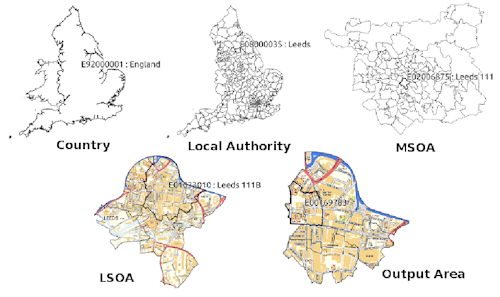

[Image source](https://census.ukdataservice.ac.uk/use-data/guides/boundary-data.aspx)

Diagram of levels of UK geography and how Lower Super Output Areas fit in (the colours refer to the way that geographic data is grouped in the Census, but can be ignored here):

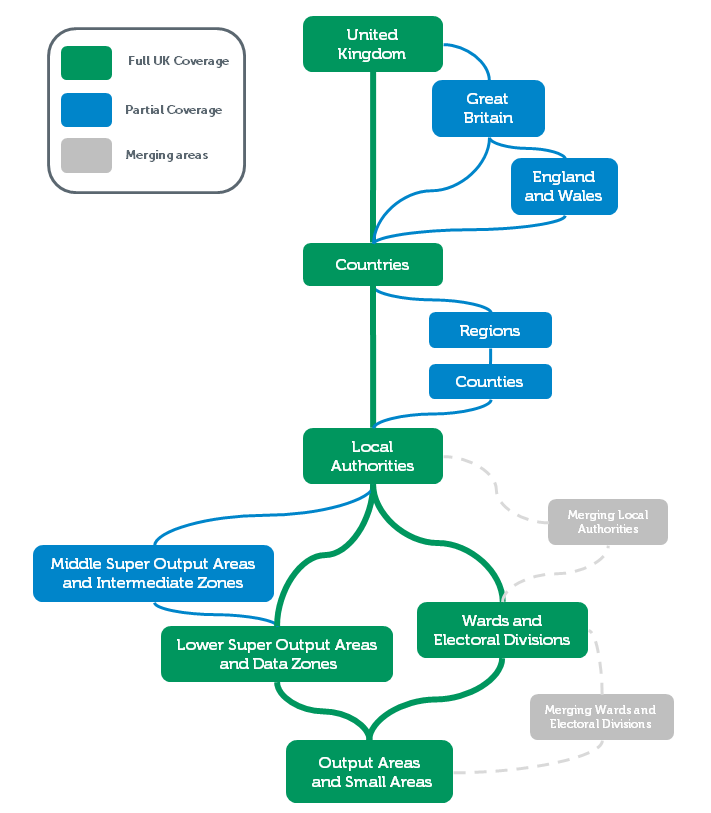
[Image source](http://infuse.ukdataservice.ac.uk/help/definitions/2011geographies/index.html)

Population data is available on the level of Output Area. However, the accident dataset used in this project only uses Lower Super Output Area. Therefore this level of data will be used.

In [409]:
population = pd.read_csv('data/population/census_2011_population_per_lsoa.csv')
population.head()

,date,geography,geography code,Rural Urban,Variable: All usual residents; measures: Value,Variable: Males; measures: Value,Variable: Females; measures: Value,Variable: Lives in a household; measures: Value,Variable: Lives in a communal establishment; measures: Value,Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value,Variable: Area (Hectares); measures: Value,Variable: Density (number of persons per hectare); measures: Value
0,2011,Darlington 001B,E01012334,Total,2466,1220,1246,2466,0,42,6033.58,0.4
1,2011,Darlington 001C,E01012335,Total,1383,682,701,1383,0,21,114.01,12.1
2,2011,Darlington 001D,E01012366,Total,2008,972,1036,2008,0,30,6718.16,0.3
3,2011,Darlington 001E,E01033481,Total,1364,680,684,1350,14,21,146.95,9.3
4,2011,Darlington 001F,E01033482,Total,1621,810,811,1621,0,16,234.31,6.9


In [410]:
# Dropping unnecessary columns
population.drop(['date', 'geography', 'Rural Urban', 'Variable: Males; measures: Value', 'Variable: Females; measures: Value', 'Variable: Lives in a household; measures: Value', 'Variable: Lives in a communal establishment; measures: Value', 'Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value'], axis=1, inplace=True)

In [412]:
# Renaming columns to make them clearer
population.rename({'geography code': 'LSOA', 'Variable: All usual residents; measures: Value': 'population_count', 'Variable: Area (Hectares); measures: Value': 'hectares', 'Variable: Density (number of persons per hectare); measures: Value': 'population_per_hectare'}, axis=1, inplace=True)

In [413]:
population.head()

,LSOA,population_count,hectares,population_per_hectare
0,E01012334,2466,6033.58,0.4
1,E01012335,1383,114.01,12.1
2,E01012366,2008,6718.16,0.3
3,E01033481,1364,146.95,9.3
4,E01033482,1621,234.31,6.9


In [414]:
population.isna().sum()

LSOA                      0
population_count          0
hectares                  0
population_per_hectare    0
dtype: int64

In [415]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34753 entries, 0 to 34752
Data columns (total 4 columns):
LSOA                      34753 non-null object
population_count          34753 non-null int64
hectares                  34753 non-null float64
population_per_hectare    34753 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.1+ MB


**Quick data summary**

In [416]:
print("The total population count in England and Wales in 2011 was {0:,.0f}".format(population['population_count'].sum()))
print(f"There are between {min(population['population_count'])} and {max(population['population_count'])} people per LSOA")
print("The average population per LSOA is", round(population['population_count'].mean()))
print(f"LSOAs are between {round(min(population['hectares']),1)} and {round(max(population['hectares']),1)} hectares")
print(f"The average LSOA is {round(population['hectares'].mean(),1)} hectares")

The total population count in England and Wales in 2011 was 56,075,912
There are between 983 and 8300 people per LSOA
The average population per LSOA is 1614
LSOAs are between 1.8 and 67283.5 hectares
The average LSOA is 434.5 hectares


**Exporting the final dataset**

In [417]:
population = population[['LSOA', 'population_per_hectare']]

In [418]:
#population.to_csv('data/population/Population_density.csv', index=False)

***

## Merging the traffic, population and accident datasets for London

In this section, the cleaned traffic and population datasets will be merged with the accident dataset from notebook 1.

**Filtering the accident database to only contain the area under study**

For the purposes of this project, and particularly the convolutional neural network models (CNN), it is preferable to include satellite images (and therefore accident data) from a predominantly built-up area. Otherwise, there is a risk that a lot of the images for areas which have not had accidents would be fields, forests or bodies of water, which would mean that the CNN would simply learn to distinguish between images of nature (e.g. mostly green or blue) and images of roads and buildings (e.g. mostly grey or brown), rather than learning the features of roads that make them more or less potentially dangerous in terms of traffic accidents.

This project will focus on London, as it is by far the biggest city in the UK (population over 8 million) and contains a mix of city centre areas, suburbs and major and minor roads, while avoiding major bodies of water and national parks without roads. In order to include a variety of different road types, a bounding box will be used around the M25, which is the major motorway (highway) that circles London, as demonstrated in the image below.

Latitude and longitude ranges:
- Latitude: 51.257 to 51.719
- Longitude: -0.542 to 0.291

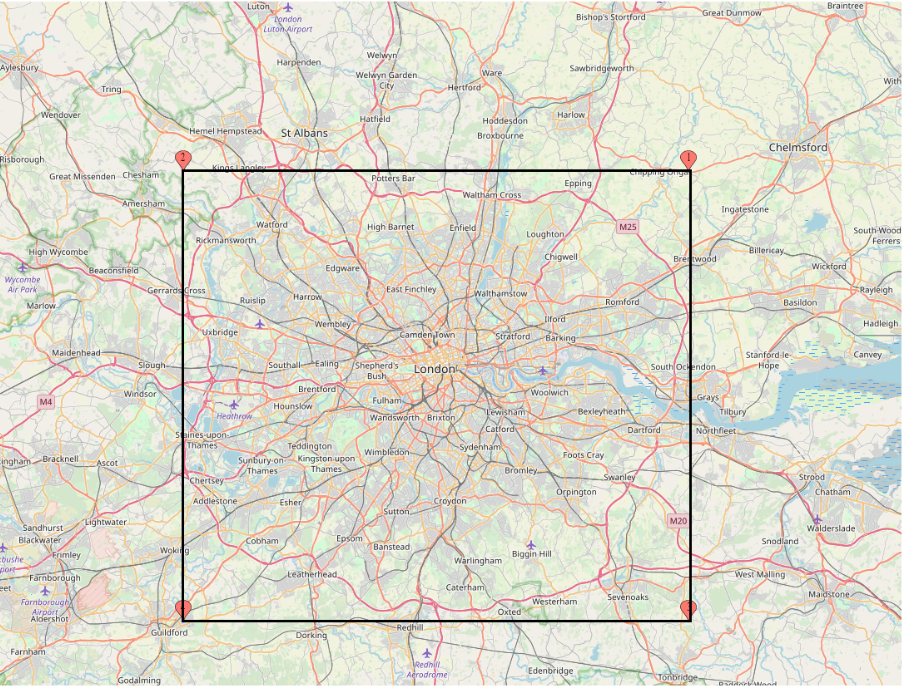

In [419]:
# Importing the accident dataset
accidents = pd.read_csv('data/accidents/Accidents.csv')

In [420]:
# Defining the area under study
lat_min, lat_max = 51.257, 51.719
long_min, long_max = -0.542, 0.291

In [421]:
london_accidents = accidents[(accidents['Latitude'].between(lat_min, lat_max))
                             & (accidents['Longitude'].between(long_min, long_max))].copy()

**Adding the population density dataset to the London accident dataset**

The accident dataset and the population density dataset both contain columns for LSOA, so can be merged on this column.

In [422]:
# Merging the population and accident datasets
london_accidents = pd.merge(london_accidents, population, how='left', left_on='LSOA_of_Accident_Location', right_on='LSOA')

# Dropping the duplicated LSOA field
london_accidents.drop('LSOA_of_Accident_Location', axis=1, inplace=True)

**Adding the traffic dataset to the accident dataset**

The traffic dataset is more difficult to merge because it does not contain LSOAs, and the probability of a traffic count being conducted at exactly the same latitude and longitude as a traffic accident is very small. Instead, each accident will be matched with the traffic counts from the nearest traffic count point. The cKDTree function from SciPy will be used for this. This function creates a tree that describes the relationship between a set of points (in this case the traffic count coordinates). This tree can then be queried to find the nearest neighbour for each point in another set of points (in this case the accident coordinates).

There is a small risk that in a small number of edge cases the counts might not be for the road the accident was on (e.g. if in the same grid square there is an accident on a minor road that joins onto a major road, and the accident was on the small road but the count is on the major road). However, it is preferable to trying to match on road name, because this would have more issues - e.g. major roads are long and will have multiple points at which the traffic was measured, and most small roads are recorded as 'U' for Unclassified (in the UK, 'Unclassified' roads are small roads and streets which have low traffic, and have names (e.g. 'High Street') instead of being part of the major road numbering system).

In [425]:
# Extract lat and long subsets from the traffic and accident dataframes
traffic_coords = traffic_averages[['S Ref Latitude', 'S Ref Longitude']]
london_accidents_coords = london_accidents[['Latitude', 'Longitude']]

# Construct tree
tree = cKDTree(traffic_coords)

# Query the tree
distances, indices = tree.query(london_accidents_coords)

In [432]:
# Get the traffic dataframe in the order that matches up with the London accidents dataframe
traffic_ordered = traffic_averages.loc[indices]
traffic_ordered.reset_index(drop=True, inplace=True)

In [440]:
# Joining the traffic and accident dataframes
london_accidents_merged = london_accidents.join(traffic_ordered)

In [464]:
# Dropping unecessary location columns
london_accidents_merged.drop(['Location_Easting_OSGR', 'Location_Northing_OSGR', 'CP', 'S Ref Latitude', 'S Ref Longitude'], axis=1, inplace=True)

In [465]:
london_accidents_merged.head()

,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,2nd_Road_Class,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Hour,Two_Hour_Groupings,Time_of_Day,Was_Daylight,Was_Bad_Weather,Was_Road_Dry,log_Number_of_Casualties,log_Number_of_Vehicles,LSOA,population_per_hectare,FdPC,Fd2WMV,FdCar,FdBUS,FdLGV,FdHGV,Road,RCat
0,201301BS70003,-0.171402,51.486361,Serious,2,1,2013-01-02,Wednesday,A,Single carriageway,30.0,T or staggered junction,Unclassified,Daylight,Fine no high winds,Dry,Urban,9,8am-10am,Morning,Yes,No,Yes,0.000000,0.693147,E01002844,110.8,1634.4,860.4,14888.0,1139.8,2297.0,352.0,A3217,PA
1,201301BS70005,-0.173356,51.495115,Slight,1,2,2013-01-04,Friday,A,Single carriageway,30.0,Crossroads,A,Daylight,Other,Dry,Urban,8,8am-10am,Morning,Yes,Yes,Yes,0.693147,0.000000,E01002821,74.6,559.6,1516.0,28505.6,1396.2,3868.6,1003.0,A4,PA
2,201301BS70006,-0.210767,51.518353,Slight,1,1,2013-01-07,Monday,B,Single carriageway,30.0,Crossroads,B,Daylight,Fine no high winds,Dry,Urban,11,10am-12pm,Office hours,Yes,No,Yes,0.000000,0.000000,E01002878,133.4,2.6,3898.2,63274.8,763.4,15253.6,3185.8,A40,PA
3,201301BS70007,-0.209675,51.516808,Slight,2,1,2013-01-10,Thursday,B,Single carriageway,30.0,Crossroads,C,Daylight,Fine no high winds,Dry,Urban,10,10am-12pm,Office hours,Yes,No,Yes,0.000000,0.693147,E01002831,179.2,2.6,3898.2,63274.8,763.4,15253.6,3185.8,A40,PA
4,201301BS70009,-0.194332,51.492922,Slight,2,1,2013-01-04,Friday,A,One way street,30.0,T or staggered junction,Unclassified,Darkness - lights lit,Fine no high winds,Dry,Urban,17,4pm-6pm,Rush hour,No,No,Yes,0.000000,0.693147,E01002851,272.3,869.2,1229.8,20478.6,897.2,4951.6,1251.4,A3220,PA


Checking the distances between count points and accident location, to confirm that they are of a sensible order of magnitude:

In [449]:
def distance_m(lat1, lon1, lat2, lon2):
    """Returns the distance in metres between two points described by latitudes and longitudes using the Haversine formula"""
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return (12742 * asin(sqrt(a)))*1000

In [450]:
# Calculating the distances between the accident and traffic count locations in each row
distances_m = []                    
for index, row in london_accidents_merged.iterrows():
    lat1 = row['Latitude'] 
    lon1 = row['Longitude'] 
    lat2 = row['S Ref Latitude'] 
    lon2 = row['S Ref Longitude'] 
    value = distance_m(lat1, lon1, lat2, lon2) 
    distances_m.append(value)

The traffic count points for the majority of accidents are within 300m, which is an acceptable level. Distances range from 0.1 metres up to 5km. The latter is most likely to be the cases of less built-up areas further from the city centre.

In [457]:
print("Mean:", round(np.mean(distances_m),1))
print("Median:", round(np.median(distances_m),1))
print("Minimum:", round(min(distances_m),1))
print("Maximum:", round(max(distances_m),1))

Mean: 383.3
Median: 285.0
Minimum: 0.1
Maximum: 4917.7


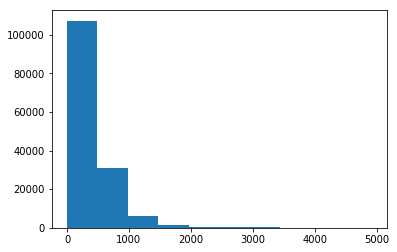

In [462]:
# Checking the distribution of distances
plt.hist(distances_m);

In [466]:
# Exporting the data
#london_accidents_merged.to_csv('data/accidents/London_accidents_merged.csv', index=False)

***

## Getting the list of locations to download satellite images for

For models 2 and 3, which use convolutional neural networks to predict traffic accident locations, it is necessary to download satellite images for a sample of areas that are more and less dangerous in terms of traffic accidents. For the purposes of this project, 'dangerous' areas are classified as those that have had one or more traffic accidents in the years the data covers (2013-2017), and 'safe' areas are classified as those that did not have any traffic accidents during this period.

In order to get a set of 'dangerous' and 'safe' areas which do not overlap, a grid system was created and used by splitting London into squares of 0.0005 latitude x 0.0005 longitude (which also allows for easy rounding of locations in the accident dataset). This corresponds to grid squares (technically rectangles) of 56m high (latitude) and 35m wide (longitude), which is similar to the 30m x 30m stated by [this paper](https://pdfs.semanticscholar.org/ef28/efaa43a05be548ed61d52a6bd590b88e7782.pdf) to be a common area size for traffic accident analysis.

The image below demonstrates the size of these grid quares, overlaid over a map of traffic accidents in an area of central London - the pattern of these along roads can clearly be seen.

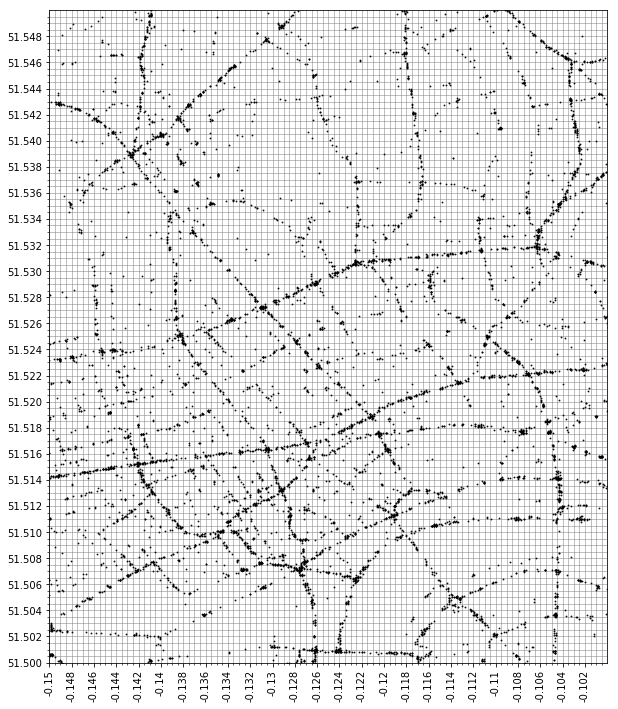

In [41]:
xticks = np.arange(-0.15, -0.1, 0.002)
fig, ax = plt.subplots(figsize=(10,12))
ax.scatter(london_accidents_merged.Longitude, london_accidents_merged.Latitude, s=0.7, alpha=0.9, color='black')
ax.set_xlim(-0.15, -0.1)
ax.set_ylim(51.5, 51.55)
ax.set_xticks(xticks)
ax.set_yticks(np.arange(51.5, 51.55, 0.002))
ax.set_xticklabels(xticks.round(4), rotation=90)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which='both', linestyle='-', linewidth='0.5', color='grey')

In [654]:
# Setting parameters
grid_size = 0.0005

# Getting a list of all grid squares
lats = np.linspace(lat_min, lat_max, 925)
lons = np.linspace(long_min, long_max, 1667)
coords = [(round(x,4),round(y,4)) for x in lats for y in lons]

# Converting to a dataframe and adding a column for the grid square name
# in the correct format for the Google Static Maps API (where satellite images will be downloaded from)
coords = pd.DataFrame(coords, columns=['lat_4dp', 'long_4dp'])
coords['grid_square'] = coords['lat_4dp'].map(str) + "," + coords['long_4dp'].map(str)
coords.head()

,lat_4dp,long_4dp,grid_square
0,51.257,-0.5420,"51.257,-0.542"
1,51.257,-0.5415,"51.257,-0.5415"
2,51.257,-0.5410,"51.257,-0.541"
3,51.257,-0.5405,"51.257,-0.5405"
4,51.257,-0.5400,"51.257,-0.54"


In [526]:
def myround(x, base=.0005):
    return base * round(x/base)

In [527]:
# Adding rounded lat and long columns and a grid square column to the London accident dataset
london_accidents_merged['lat_4dp'] = myround(london_accidents_merged['Latitude'])
london_accidents_merged['long_4dp'] = myround(london_accidents_merged['Longitude'])
london_accidents_merged['grid_square'] = round(london_accidents_merged['lat_4dp'],4).map(str) + "," + round(london_accidents_merged['long_4dp'],4).map(str)

In [642]:
london_accidents_merged.head()

,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,2nd_Road_Class,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Hour,Two_Hour_Groupings,Time_of_Day,Was_Daylight,Was_Bad_Weather,Was_Road_Dry,log_Number_of_Casualties,log_Number_of_Vehicles,LSOA,population_per_hectare,FdPC,Fd2WMV,FdCar,FdBUS,FdLGV,FdHGV,Road,RCat,lat_4dp,long_4dp,grid_square
0,201301BS70003,-0.171402,51.486361,Serious,2,1,2013-01-02,Wednesday,A,Single carriageway,30.0,T or staggered junction,Unclassified,Daylight,Fine no high winds,Dry,Urban,9,8am-10am,Morning,Yes,No,Yes,0.000000,0.693147,E01002844,110.8,1634.4,860.4,14888.0,1139.8,2297.0,352.0,A3217,PA,51.4865,-0.1715,"51.4865,-0.1715"
1,201301BS70005,-0.173356,51.495115,Slight,1,2,2013-01-04,Friday,A,Single carriageway,30.0,Crossroads,A,Daylight,Other,Dry,Urban,8,8am-10am,Morning,Yes,Yes,Yes,0.693147,0.000000,E01002821,74.6,559.6,1516.0,28505.6,1396.2,3868.6,1003.0,A4,PA,51.4950,-0.1735,"51.495,-0.1735"
2,201301BS70006,-0.210767,51.518353,Slight,1,1,2013-01-07,Monday,B,Single carriageway,30.0,Crossroads,B,Daylight,Fine no high winds,Dry,Urban,11,10am-12pm,Office hours,Yes,No,Yes,0.000000,0.000000,E01002878,133.4,2.6,3898.2,63274.8,763.4,15253.6,3185.8,A40,PA,51.5185,-0.2110,"51.5185,-0.211"
3,201301BS70007,-0.209675,51.516808,Slight,2,1,2013-01-10,Thursday,B,Single carriageway,30.0,Crossroads,C,Daylight,Fine no high winds,Dry,Urban,10,10am-12pm,Office hours,Yes,No,Yes,0.000000,0.693147,E01002831,179.2,2.6,3898.2,63274.8,763.4,15253.6,3185.8,A40,PA,51.5170,-0.2095,"51.517,-0.2095"
4,201301BS70009,-0.194332,51.492922,Slight,2,1,2013-01-04,Friday,A,One way street,30.0,T or staggered junction,Unclassified,Darkness - lights lit,Fine no high winds,Dry,Urban,17,4pm-6pm,Rush hour,No,No,Yes,0.000000,0.693147,E01002851,272.3,869.2,1229.8,20478.6,897.2,4951.6,1251.4,A3220,PA,51.4930,-0.1945,"51.493,-0.1945"


In [655]:
# Creating a list of all squares
all_squares = coords.grid_square
len(all_squares)

1541975

In [643]:
# Creating a list of danger squares
danger_squares = london_accidents_merged.grid_square
danger_squares.drop_duplicates(inplace=True)
len(danger_squares)

69757

In [656]:
# Creating a list of safe squares (all_squares minus danger_squares)
safe_squares = list(set(all_squares) - set(danger_squares))
len(safe_squares)

1472218

Getting lists of 5,000 samples from safe and danger squares, for use in model 2:

In [668]:
danger_squares_download = list(np.random.choice(list(danger_squares), size=5000, replace=False))
safe_squares_download = list(np.random.choice(list(safe_squares), size=5000, replace=False))

***

## Downloading satellite images for model 2

The satellite images for each area will be downloaded using Google Static Maps API.

In [674]:
def GetImage(coord,SaveLoc):
    base = "https://maps.googleapis.com/maps/api/staticmap?size=375x600&zoom=20&scale=1&maptype=satellite&format=png&visual_refresh=true&center="
    MyUrl = base + coord + key
    file = coord + ".jpg"
    urllib.request.urlretrieve(MyUrl, os.path.join(SaveLoc,file))

In [676]:
key = "&key=" + "" # API key - kept private
myloc = r"" # File path - kept private

for i in danger_squares_download:
    GetImage(coord=i,SaveLoc=myloc)